# Stromverbrauchsprognose unter Verwendung von Wetterdaten
In diesem Projekt soll anhand von bereitgestellten Wetter- und Energieverbrauchsinformationen eine Prognose für den Energieverbrauch 1h bzw. 24h nach vorne erstellt werden. Als Zeitraum werden hierfür die Monate Juni bis August 2011 untersucht.

## Setup

In [2]:
#
import pandas as pd

#
import matplotlib.pyplot as plt
import seaborn as sns

#Show mulitple outputs within one kernel-----------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
#pd.set_option('display.float_format', lambda x: '%.3f' % x) #diplay command only show the first 5 digits

# 1. Überblick und  Datenbereinigung 
Wir arbeiten hierfür mit zwei Datensätzen.
* 'SystemLevelSummer.csv' enthält Informationen zum Stromverbrauch. 
* 'weatherDFLocalSummer.csv' enthält Wetterinformationen, welche im Wesentlichen vorhergesagt werden sollen.

## 1.1 Laden der Datensätze

In [3]:
powerDF = pd.read_csv('./data/SystemLevelSummer.csv')
weatherDF = pd.read_csv('./data/WeatherLocalSummer.csv')

In [14]:
powerDF.columns
powerDF.head()

Index(['TOTAL_LOAD', 'MONTH', 'DAY'], dtype='object')

,TOTAL_LOAD,MONTH,DAY
#DATE,,,
2011-06-01 00:15:00,639691.499583,6,1
2011-06-01 00:30:00,624777.006874,6,1
2011-06-01 00:45:00,610658.780201,6,1
2011-06-01 01:00:00,597351.542302,6,1
2011-06-01 01:15:00,583547.506936,6,1


In [15]:
weatherDF.columns
weatherDF.head()

Index(['TEMPERATURE[F]', 'HUMIDITY[%]', 'PRESSURE[inHg]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY'],
      dtype='object')

,TEMPERATURE[F],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-05-30 17:00:00,86.635,51.563,29.941,7.523,0.0,5,30
2011-05-30 18:00:00,84.931,56.044,29.945,7.453,0.0,5,30
2011-05-30 19:00:00,83.100,61.551,29.952,6.930,0.0,5,30
2011-05-30 20:00:00,80.823,69.142,29.967,6.979,0.0,5,30
2011-05-30 21:00:00,79.305,75.395,29.983,6.677,0.0,5,30


## 1.2 Überarbeitung der Datenstruktur
Nachfolgend sollen die Datensätze so überarbeitet werden, damit diese im weiteren Verlauf sinnvoll untersucht werden können.

In [6]:
def generalModification(df):
    #General Modifications---------------------
    df.columns = df.columns.str.replace(" ", "")

    #Date Modifications------------------------
    df['#DATE'] = pd.to_datetime(df['#DATE'])
    df = df.set_index('#DATE').sort_index()

    #Separate the datetime in separate columns
    df['MONTH'] = df.index.month
    df['DAY'] = df.index.day

    return df

In [7]:
powerDF = generalModification(powerDF)
weatherDF = generalModification(weatherDF)

#### 1.2.1 powerDF
Zudem sind die Zeitabstände von powerDF ...., deswegen ... . 
Dazu rechnen wir die einzelnen Werte zusammen, da
(Möglich da keine Lücken)

In [19]:
powerDF = powerDF.resample('h').sum()

#### 1.2.2 weatherDF
Fahrenheit zu Celcius

In [20]:
weatherDF['TEMPERATURE[F]'] = (weatherDF['TEMPERATURE[F]']-32)/1.8
weatherDF = weatherDF.rename(columns={'TEMPERATURE[F]': 'TEMPERATURE[C]'})

## 1.2 Überblick über die Daten 
Zunächst soll sich von den Datensätzen ein grober Überblick verschaffen werden, um sie gegebenenfalls sinnvoll zu bearbeiten bzw. aneinander anzupassen.
Aus dem Datensatz mit dem Stromverbrauch (Einheit kWh) ist bereits zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 bis 01.09.2011 im 15-Minutentakt aufgenommen worden sind. Der Datensatz mit den Wetterdaten hingegen bezieht sich auf den Zeitraum 30.05.2011

In [8]:
powerDF.columns
powerDF

Index(['TOTAL_LOAD', 'MONTH', 'DAY'], dtype='object')

,TOTAL_LOAD,MONTH,DAY
#DATE,,,
2011-06-01 00:15:00,639691.499583,6,1
2011-06-01 00:30:00,624777.006874,6,1
2011-06-01 00:45:00,610658.780201,6,1
2011-06-01 01:00:00,597351.542302,6,1
2011-06-01 01:15:00,583547.506936,6,1
...,...,...,...
2011-08-31 23:00:00,847367.609038,8,31
2011-08-31 23:15:00,822442.490218,8,31
2011-08-31 23:30:00,802867.468608,8,31


In [13]:
weatherDF.columns
weatherDF

Index(['TEMPERATURE[F]', 'HUMIDITY[%]', 'PRESSURE[inHg]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY'],
      dtype='object')

,TEMPERATURE[F],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-05-30 17:00:00,86.635,51.563,29.941,7.523,0.0,5,30
2011-05-30 18:00:00,84.931,56.044,29.945,7.453,0.0,5,30
2011-05-30 19:00:00,83.100,61.551,29.952,6.930,0.0,5,30
2011-05-30 20:00:00,80.823,69.142,29.967,6.979,0.0,5,30
2011-05-30 21:00:00,79.305,75.395,29.983,6.677,0.0,5,30
...,...,...,...,...,...,...,...
2011-09-01 12:00:00,88.686,55.515,29.945,5.650,0.0,9,1
2011-09-01 13:00:00,90.327,49.891,29.923,5.407,0.0,9,1
2011-09-01 14:00:00,93.014,41.848,29.895,5.461,0.0,9,1


In [9]:
powerDF.describe()
weatherDF.describe()

,TOTAL_LOAD,MONTH,DAY
count,8.832000e+03,8832.000000,8832.000000
mean,9.364204e+05,7.011209,15.836957
std,2.430150e+05,0.814452,8.854728
min,4.746091e+05,6.000000,1.000000
25%,7.120265e+05,6.000000,8.000000
50%,9.289187e+05,7.000000,16.000000
75%,1.150144e+06,8.000000,23.250000
max,1.433244e+06,9.000000,31.000000


,TEMPERATURE[F],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,84.193374,64.212354,29.917043,3.917266,0.007017,6.998227,15.930408
std,6.444205,18.236110,0.075241,1.932054,0.059717,0.856951,9.026840
min,66.617000,21.227000,29.719000,0.000000,-0.180000,5.000000,1.000000
25%,79.109750,47.808250,29.867750,2.487000,0.000000,6.000000,8.000000
50%,82.881000,66.830500,29.912500,3.733500,0.000000,7.000000,16.000000
75%,89.305750,81.200250,29.959000,5.313000,0.000000,8.000000,24.000000
max,102.894000,98.210000,30.197000,11.592000,1.800000,9.000000,31.000000


In [16]:
powerDF.isna().any().any()
weatherDF.isna().any().any()

False

False

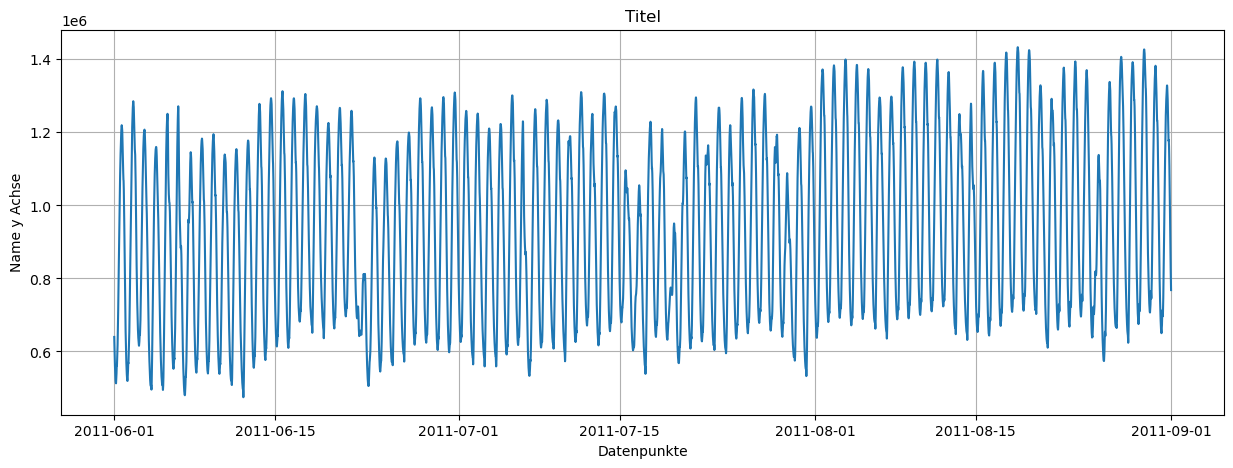

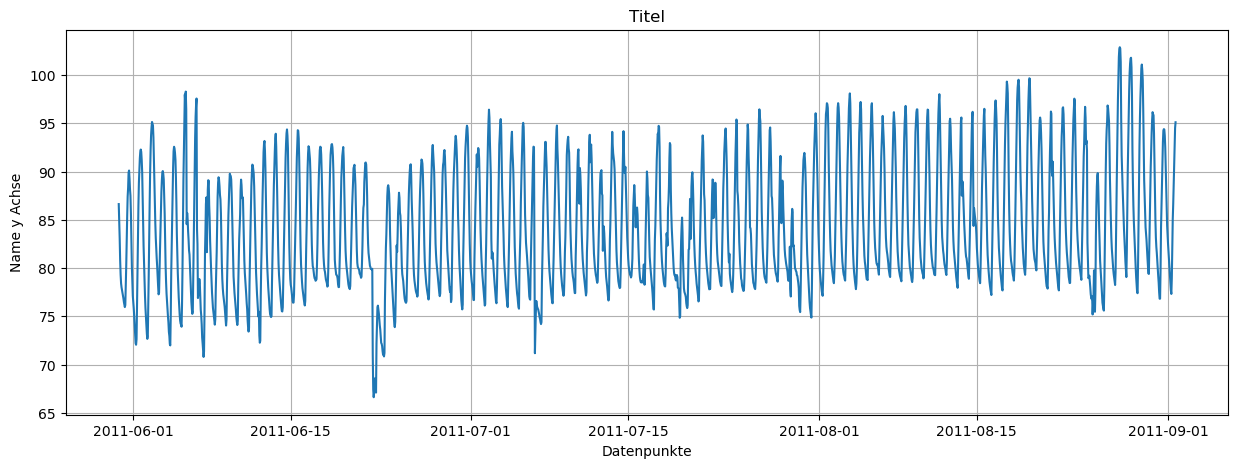

In [18]:
#Ilona: Titel, Beschriftung der Achsen (Bei dem Wetterdatensatz dementsprechend allgmein), Legende einheitlich , Zeit als Index (noch nicht das df ändern, das kommt später)und was sonst noch einfällt 
def plotDF(df, column, title, y_axis):
    plt.figure(figsize=(15, 5))

    plt.plot(df.index, df[column])

    plt.title(title)
    plt.xlabel('Datenpunkte')
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

plotDF(powerDF, 'TOTAL_LOAD', 'Titel', 'Name y Achse')
plotDF(weatherDF, 'TEMPERATURE[F]', 'Titel', 'Name y Achse')


 Beschreibung der Datensätze 
* *Spalten, INformationen, Länge(count), Aufzeichungsabstände, Lücken? Extreme Ausreißer? Zeitraum? Einheiten?

## 1.3 Datenbereinigung
Für die Übersicht und ....

### Verfeinerte Anpassung

Anderer Zeitraum ... Anpassung durch....

In [ ]:
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

# 2. Datenanalyse

# 2.1 Linearität

## 2.2 Periodizität
Widerholende Struktur innerhalb der daten zu beobachten, speziell in TEmperatur, Feuchtigkeit; Windstärke und Stromverbrauch. Deswegen genauere Betrachtung

<Axes: xlabel='#DATE'>

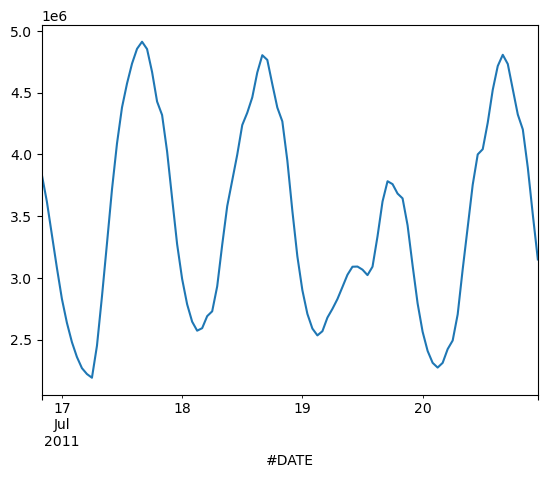

In [ ]:
#PLot mit den relevanten Spalten aus beiden Dataframes
powerDF['TOTAL_LOAD'][1100:1200].plot()

## 2.3 Korrelation 

<Axes: >

Text(0.5, 1.0, 'Korrelationsmatrix der Wetter- und Stromdaten')

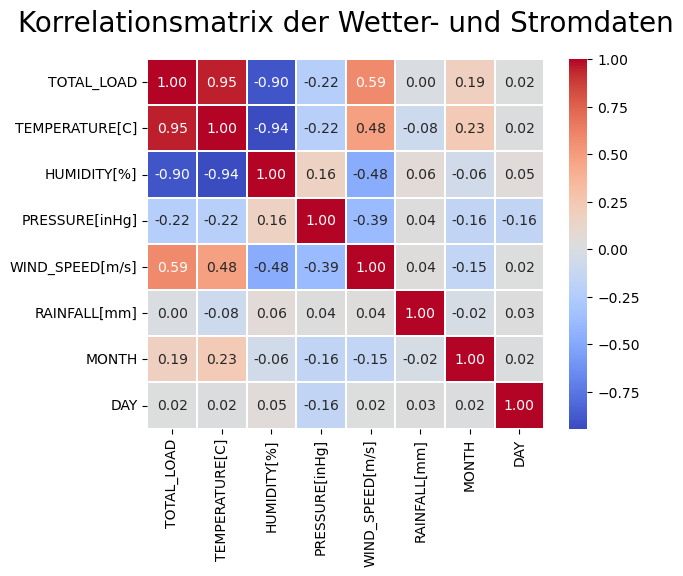

In [ ]:
#Merge df in order to compare all relevant columns and drop duplicates
necCol = powerDF.columns.difference(weatherDF.columns)
mergedDF = pd.merge(powerDF[necCol], weatherDF, on='#DATE')

corrMatrix = mergedDF.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Korrelationsmatrix der Wetter- und Stromdaten', size=20, pad = 20)
plt.show()

Was ist zu sehen? 

p Value etc. 

## 2.4 Ausreißer 

#Funktion schreiben die diese detektiert
22.06.2011 
https://www.spiegel.de/panorama/regen-hagel-sturm-tausende-haushalte-nach-unwetter-ohne-strom-a-769966.html 

19.07.2011 ??? 

<Axes: xlabel='#DATE'>

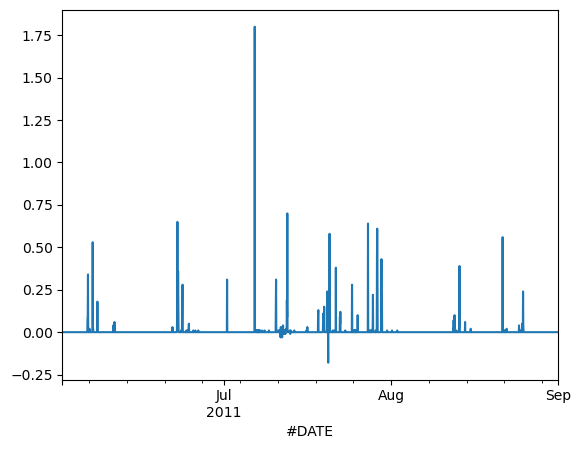

In [ ]:
weatherDF['RAINFALL[mm]'].plot()